In [1]:
# Think Complexity
# Chapter 7: Physical modeling

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

In [3]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array

class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""
    kernel = np.array([[0, 1, 0],
                      [1, -4, 1],
                      [0, 1, 0]])
    def __init__(self, n, r=0.1):
        """Initializes the attributes.
        n: number of rows
        r: diffusion rate constant
        """
        self.r = r
        self.array = np.zeros((n, n), np.float)
    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.
        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])
    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Reds')

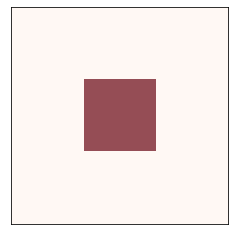

In [4]:
# Here's a simple example starting with an "island" of material in the middle.
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
diff.draw()

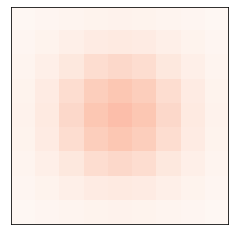

In [5]:
diff.animate(frames=20, interval=0.1)

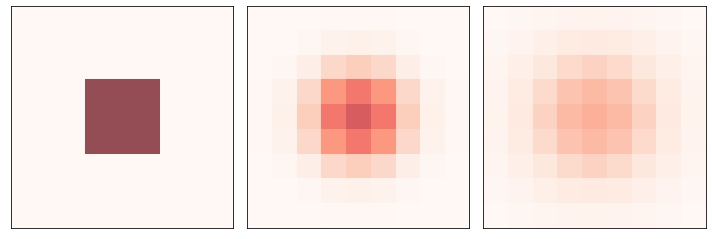

In [6]:
from utils import three_frame

diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
three_frame(diff, [0, 5, 10])

In [7]:
# Reaction-Diffusion

In [8]:
# The following function helps with setting up the initial conditions.
def add_island(a, height=0.1):
    """Adds an island in the middle of the array.
    height: height of the island
    """
    n, m = a.shape
    radius = min(n, m) // 20
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] += height

In [9]:
# For the RD model, we have two arrays, one for each chemical.
class ReactionDiffusion(Diffusion):
    """Reaction-Diffusion Cellular Automaton."""
    kernel = np.array([[0.05, 0.2, 0.05],
                      [0.2, -1, 0.2],
                      [0.05, 0.2, 0.05]])
    def __init__(self, n, params, noise=0.1):
        """Initializes the attributes.
        n: number of rows
        params: tuple of (Da, Db, f, k)
        """
        self.params = params
        self.array1 = np.ones((n, n), dtype=float)
        self.array2 = noise * np.random.random((n,n))
        add_island(self.array2)
    def step(self):
        """Executes one time step."""
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params
        
        options = dict(mode='same', boundary='wrap')
        
        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        self.array1 += ra * cA - reaction + f * (1-A)
        self.array2 += rb * cB + reaction - (f+k) * B
    def loop100(self):
        self.loop(100)
    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic',
                      vmin=None, vmax=None)
        draw_array(self.array1, cmap='Reds', **options)
        draw_array(self.array2, cmap='Blues', **options)
        

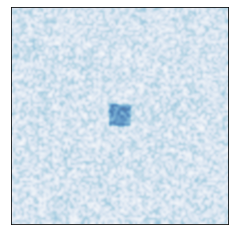

In [10]:
params1 = 0.5, 0.25, 0.035, 0.057 # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062 # coral
params3 = 0.5, 0.25, 0.039, 0.065 # blue spots

rd = ReactionDiffusion(n=100, params=params1)
rd.draw()


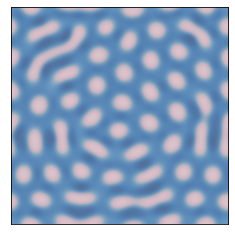

In [11]:
# Here's a random starting condition with lots of A, a sparinkling of B everywhere, and an island of B in the middle.
rd.animate(frames=50, step=rd.loop100)

In [12]:
def make_rd(f, k, n=100):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params)
    return rd

In [13]:
from utils import three_frame
def plot_rd(f, k):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(100, params)
    three_frame(rd, [1000, 2000, 4000])

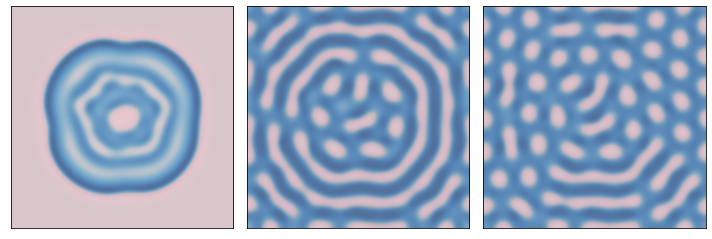

In [14]:
plot_rd(0.035, 0.057)

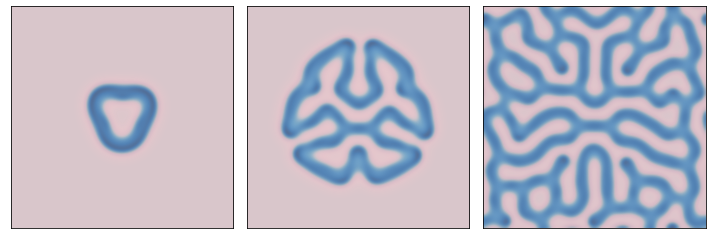

In [15]:
plot_rd(0.055, 0.062)

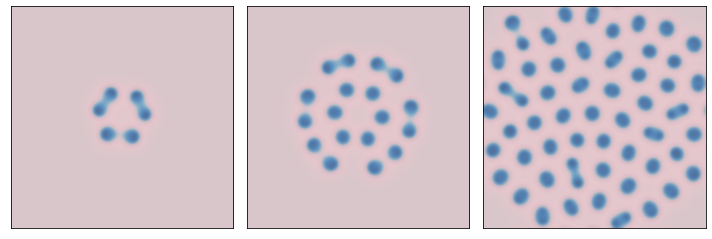

In [16]:
plot_rd(0.039, 0.065)

In [17]:
from scipy.signal import correlate2d
from Cell2D import Cell2D

class Percolation(Cell2D):
    """Percolation Cellular Automaton."""
    
    kernel = np.array([[0, 1, 0],
                      [1, 0, 1],
                      [0, 1, 0]])
    def __init__(self, n, q=0.5):
        """Initializes the attributes.
        
        n: number of rows
        q: probability of porousness
        """
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])
        
        # fill the top row with wet cells
        self.array[0] = 5
    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=5)

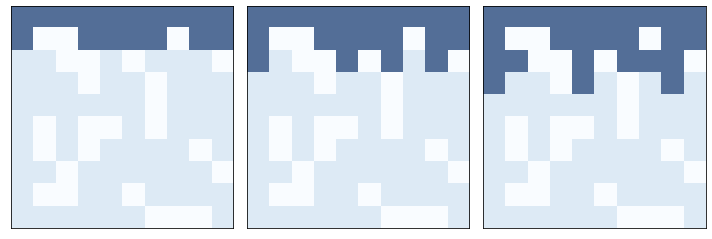

In [18]:
# Here an example that shows the first three time steps.
n = 10
q = 0.7
np.random.seed(18)
perc = Percolation(n, q)
three_frame(perc, [1, 1, 1])

In [19]:
# test_perc runs a percolation model and returns True if water reaches the bottom row and False otherwise.
def test_perc(perc):
    """Run a percolation model.
    Runs until water gets to the bottom row or nothing changes.
    returns: boolean, whether ther's a percolating cluster
    """
    num_wet = perc.num_wet()
    while True:
        perc.step()
        if perc.bottom_row_wet():
            return True
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False
        num_wet = new_num_wet

In [20]:
# Run a small example.
np.random.seed(18)
perc = Percolation(n, q)
test_perc(perc)

True

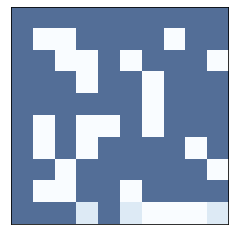

True

In [21]:
# And here's the animation
np.random.seed(18)
perc = Percolation(n, q)
perc.animate(frames=12, interval=0.3)
test_perc(perc)

In [22]:
# For a given q we can estimate the probability of a percolating cluster by running several random configurations.
def estimate_prob_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating.
    
    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of arrays to test
    
    returns: float probability
    """
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

In [23]:
# At q=0.55 the probability is low.
fraction = estimate_prob_percolating(q=0.55)
print(fraction)

0.0


In [24]:
# At q=0.6, the probability is close to 50%, which suggests thath the critical value is nearby.
fraction = estimate_prob_percolating(q=0.6)
print(fraction)

0.71


In [25]:
# At q=0.65 the probability is high.
fraction = estimate_prob_percolating(q=0.65)
print(fraction)

1.0


In [26]:
# We can search for the critical value by random walk: if there's a percolating cluster, we decrease q;
# otherwise we increase it.
# The path should go to the critical point and wander arouond it.
def find_critical(n=100, q=0.6, iters=100):
    """Estimate q_crit by random walk.
    returns: list of q that should wander around q_crit
    """
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

Wall time: 7.55 s


0.5932367632367631

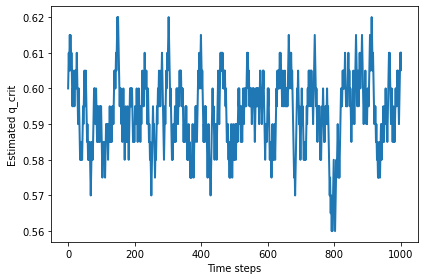

In [27]:
# Let's see whether the critical value depends on the size of the grid.
# With n=50, the random walk wanders around 0.59.
%time qs = find_critical(n=50, iters=1000)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Wall time: 11.3 s


0.5933830845771144

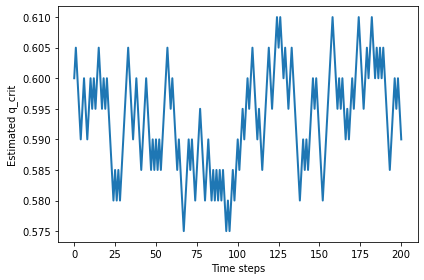

In [28]:
%time qs = find_critical(n=100, iters=200)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Wall time: 17.6 s


0.5912195121951219

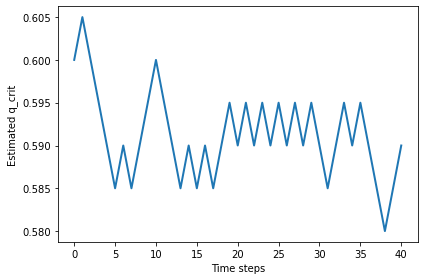

In [29]:
%time qs = find_critical(n=200, iters=40)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Wall time: 37 s


0.5968181818181817

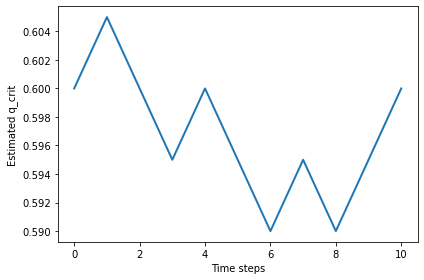

In [30]:
%time qs = find_critical(n=400, iters=10)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

In [31]:
# Fractals

False


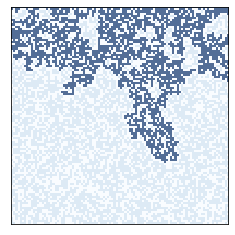

In [32]:
# Near the critical point, the cluster of wet cells forms a fractal. We can see that visually in these examples:
np.random.seed(22)
perc1 = Percolation(n=100, q=0.6)
flag = test_perc(perc1)
print(flag)
perc1.draw()

False


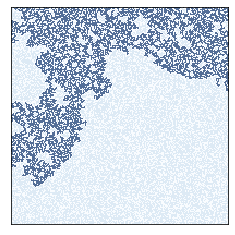

In [33]:
np.random.seed(22)
perc2 = Percolation(n=200, q=0.6)
flag = test_perc(perc2)
print(flag)
perc2.draw()

True


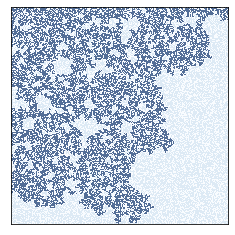

In [34]:
np.random.seed(22)
perc3 = Percolation(n=300, q=0.6)
flag = test_perc(perc3)
print(flag)
perc3.draw()

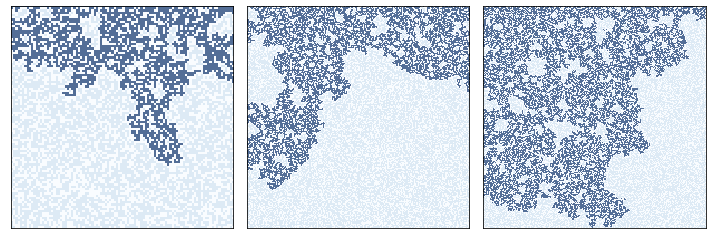

In [35]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
perc1.draw()

plt.subplot(1, 3, 2)
perc2.draw()

plt.subplot(1, 3, 3)
perc3.draw()

plt.tight_layout()

In [36]:
# To measure fractal dimension, let's start with 1D CAs.
from Cell1D import Cell1D, draw_ca

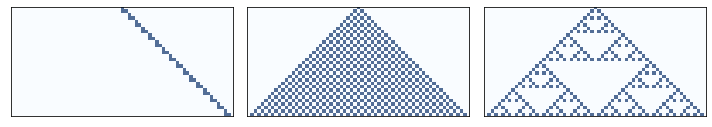

In [37]:
# Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
draw_ca(20)

plt.subplot(1, 3, 2)
draw_ca(50)

plt.subplot(1, 3, 3)
draw_ca(18)

plt.tight_layout()

In [38]:
# The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.
def count_cells(rule, n=500):
    """Create a 1-D CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

In [39]:
# This function plots the results, comparing the rate of cell growth to size and size**2.
# And it uses linregress to estimate the slope of the line on a log-log scale.

from scipy.stats import linregress

def test_fractal(rule, ylabel='Number of Cells'):
    """Compute the fractal dimension of a rule.
    
    rule: int rule number
    ylabel: string
    """
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(steps, steps2, label='d=2', **options)
    plt.plot(steps, cells, label='rule=%d' % rule)
    plt.plot(steps, steps, label='d=1', **options)

    decorate(xscale='log', yscale='log',
             xlabel='Time Steps',
             ylabel=ylabel,
             xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

1.0079212645952562


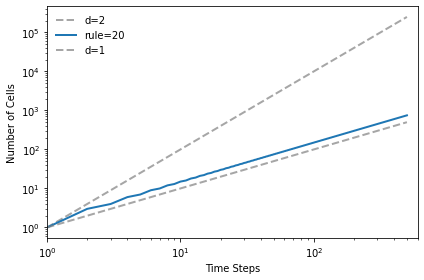

In [40]:
# The linear rule has dimension close to 1.
test_fractal(20)

1.9712808836268108


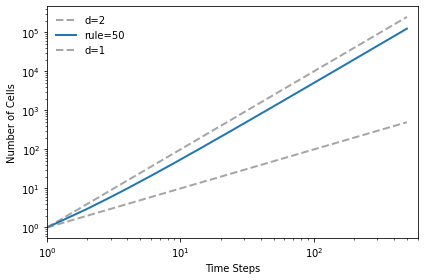

In [41]:
# The triangular rule has dimension close to 2.
test_fractal(50)

1.5739294411777087


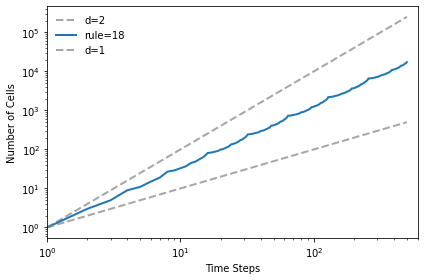

In [42]:
# And the Sierpinski triangle has fractal dimension approximately 1.57.
test_fractal(18)

1.0079212645952562
1.9712808836268108
1.5739294411777087


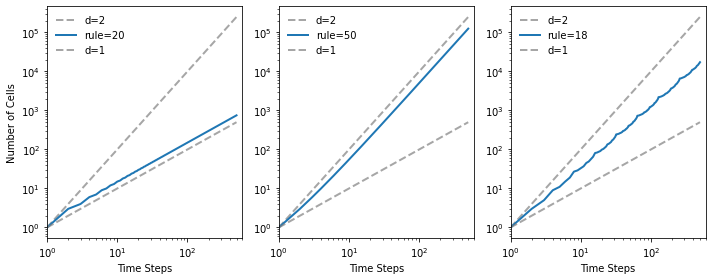

In [43]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
test_fractal(20)

plt.subplot(1, 3, 2)
test_fractal(50, ylabel='')

plt.subplot(1, 3, 3)
test_fractal(18, ylabel='')

In [44]:
# Mathematically, the frctal dimension is supposed to be:
np.log(3) / np.log(2)

1.5849625007211563

In [54]:
# Fractals in percolation models
# We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales
# as we increase the size of a bounding box.
# The following function takes a percolation model that has run to completion. It computes bounding boxes with
# sizes from 10 to n-1, positioned in the center of the array.
# For each bounding box it counts the number of wet cells.

from scipy.stats import linregress

def plot_perc_scaling(sizes, q):
    res = []
    for size in sizes:
        perc = Percolation(size, q)
        if test_perc(perc):
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
            
    sizes, cells, filled = zip(*res)
    
    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(sizes, cells, label='d=2', **options)
    plt.plot(sizes, filled, '.', label='filled')
    plt.plot(sizes, sizes, label='d=1', **options)
    
    decorate(xlabel='Array Size',
            ylabel='Cell Count',
            xscale='log', xlim=[9, 110],
            yscale='log', ylim=[9, 20000],
            loc='upper left')
    
    for ys in [cells, filled, sizes]:
        params = linregress(np.log(sizes), np.log(ys))
        print(params[0])

2.0
1.919749866933197
1.0


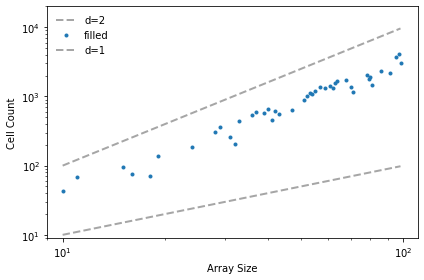

In [55]:
# If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.
# When q is near the critical point, the fractal dimension of the wet cells is usually between 1.8 and 2.0,
# but it varies from one run to the next.
sizes = np.arange(10, 101)
plot_perc_scaling(sizes, q=0.59)

In [56]:
# Exercise
# Solution
# Here's a modified version of 'count_cells' that uses 'Wrap1D'

class Wrap1D(Cell1D):
    """Implements a 1D cellular automaton with wrapping."""
    
    def step(self):
        # perform the usual step operation
        Cell1D.step(self)
        
        # fix the first and last cells by copying from the other end
        i = self.next-1
        row = self.array[i]
        row[0], row[-1] = row[-2], row[1]
        
def count_cells(rule, n=256):
    """Make a CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Wrap1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
    return res

In [57]:
# And here's a simplified version of 'test_fractal':

from scipy.stats import linregress

def test_fractal(rule):
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)
    
    params = linregress(np.log(steps), np.log(cells))
    return params[0]

In [58]:
# The following loop estimates the fractal dimension for each rule and
# makes a dictionary that maps from each unique estimate to the first
# rule that produced it.

d = {}
for rule in range(256):
    slope = test_fractal(rule)
    if slope > 1.1 and slope < 1.9:
        slope = np.around(slope, 3)
        if slope not in d:
            d[slope] = rule

In [59]:
# This function sorts the items in a dictionary by value

from operator import itemgetter

def value_sorted(d):
    return sorted(d.items(), key=itemgetter(1))

In [60]:
# Here are the unique estimated dimensions between 1.1 and 1.9: 
    
rules = []
for slope, rule in value_sorted(d):
    print(rule, slope)
    rules.append(rule)

len(rules)

1 1.124
18 1.572
22 1.582
28 1.876
37 1.123
45 1.122
75 1.126
78 1.851
105 1.104
107 1.125
109 1.145
110 1.877
126 1.609
129 1.139
137 1.121
139 1.161
150 1.692
153 1.15
169 1.159
233 1.162


20

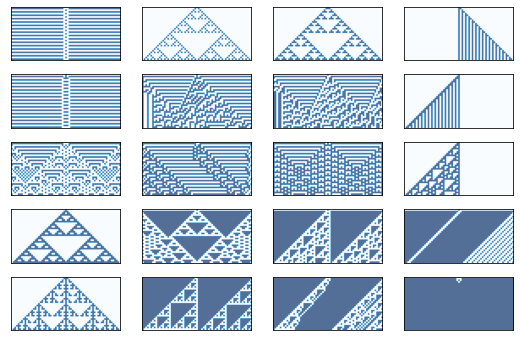

In [61]:
# And here's what the CAs look like for the rules that seem to be fractal.
# A few of these are simple patterns that are visually not fractal, 
# but most of the ones with apparently fractional dimensions also look fractal,
# including several variations on Sierpinski's triangle. 

plt.figure(figsize=(9, 6))

for i, rule in enumerate(rules):
    plt.subplot(5, 4, i+1)
    draw_ca(rule)

In [62]:
# Exercise
# Forest fire
# Solution
# Here's a class that implements a model, using the same kernel
# as the percolation model, and a similar strategy for encoding the states.

from matplotlib.colors import LinearSegmentedColormap
colors = [(0,   'white'),
          (0.2, 'Green'),
          (1.0, 'Orange')]
    
cmap = LinearSegmentedColormap.from_list('mycmap', colors)

from scipy.signal import correlate2d
from Cell2D import Cell2D

class ForestFire(Cell2D):
    """Forest Fire Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, p=0.01, f=0.001):
        """Initializes the attributes.

        n: number of rows
        p: probability of a new tree
        f: probability of a random fire
        """
        self.p = p
        self.f = f
        
        self.array = np.random.choice([1, 0], (n, n), p=[p, 1-p])

    def step(self):
        """Executes one time step."""
        p, f = self.p, self.f
        a = self.array
        c = correlate2d(a, self.kernel, mode='same', boundary='wrap')
        r = np.random.random(a.shape)
        new_tree = (a==0) & (r<p)
        new_fire = (a==1) & ((c>4) | (r<f))
        a[a==5] = 0
        a[new_tree] = 1
        a[new_fire] = 5
        
    def num_trees(self, i=None):
        """Count the number of trees.
        
        i: size of box to count
        """
        a = self.array[:i, :i]
        return np.sum(a==1)
        
    def num_fires(self, i=None):
        """Count the number of fires.
        
        i: size of box to count
        """
        a = self.array[:i, :i]
        return np.sum(a==5)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap=cmap, vmax=5)

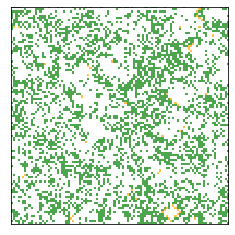

In [63]:
# Here's an example:

fire = ForestFire(100)
fire.animate(frames=200)

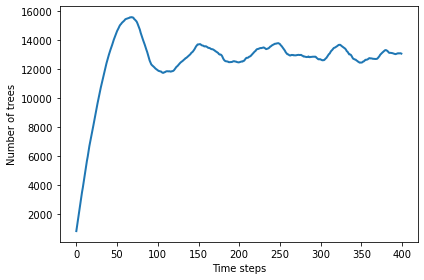

In [64]:
# Now let's see if the forest is fractal.

# I'll create a forest and run until steady state:

np.random.seed(22)
fire = ForestFire(200)
num_trees = []
for i in range(400):
    fire.step()
    num_trees.append(fire.num_trees())
    
plt.plot(num_trees)
decorate(xlabel='Time steps',
         ylabel='Number of trees')

In [65]:
# Now let's see how the number of trees scales as we
# increase the size of the bounding box:

res = []
sizes = range(10, 100)
for i in sizes:
    res.append((i**2, fire.num_trees(i), fire.num_fires(i)))

In [66]:
# Extracting the results:
    
cells, trees, fires = zip(*res)

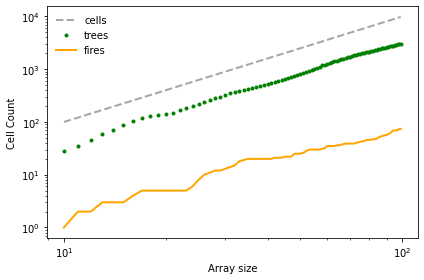

In [67]:
# And plotting them:

options = dict(linestyle='dashed', color='gray', alpha=0.7)
plt.plot(sizes, cells, label='cells', **options)
plt.plot(sizes, trees, '.', label='trees', color='green')
plt.plot(sizes, fires, label='fires', color='orange')
decorate(xlabel='Array size',
         ylabel='Cell Count',
         xscale='log', xlim=None, 
         yscale='log', ylim=None,
         loc='upper left')

In [68]:
# And computing the fractal dimension:
    
from scipy.stats import linregress

for ys in [cells, trees]:
    params = linregress(np.log(sizes), np.log(ys))
    print(params[0])

2.0
1.9686713241762006


In [69]:
# The fractal dimension varies from run to run, 
# but seems to be close to 2 most of the time.
# So it's not clear whether the forest is fractal or not.